# These are the Cartography visuals.

# To Do:
- make HA only and HA + NA sections, get snakemake notebook_docs folder ready

# Imports Section 

In [21]:
import sys
sys.path.append("../notebooks/scripts/")

In [22]:
import altair as alt
from altair_saver import save
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [23]:
alt.renderers.set_embed_options(
    padding={"left": 0, "right": 0, "bottom": 1, "top": 1}
)

RendererRegistry.enable('default')

In [24]:
sns.set_style("ticks")
# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 100
# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 8
mpl.rc('text', usetex=False)

In [25]:
try: 
    snakemake.input.node_df
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Flu Specific Variables

In [4]:
try:
    node_df = snakemake.input.node_df

    pca_df = snakemake.input.pca_df
    explained_variance_pca = snakemake.input.explained_variance_pca

    mds_df = snakemake.input.mds_df

    #Scatterplot:
    scatterplot_pca = snakemake.input.scatterplot_pca
    scatterplot_pca_metadata = snakemake.input.scatterplot_pca_metadata

    scatterplot_mds = snakemake.input.scatterplot_mds
    scatterplot_mds_metadata = snakemake.input.scatterplot_mds_metadata

    scatterplot_tsne = snakemake.input.scatterplot_tsne
    scatterplot_tsne_metadata = snakemake.input.scatterplot_tsne_metadata

    scatterplot_umap = snakemake.input.scatterplot_umap
    scatterplot_umap_metadata = snakemake.input.scatterplot_umap_metadata

    #KDE Density:
    KDE_pca = snakemake.input.KDE_pca
    KDE_pca_metadata = snakemake.input.KDE_pca_metadata

    KDE_mds = snakemake.input.KDE_mds
    KDE_mds_metadata = snakemake.input.KDE_mds_metadata

    KDE_tsne = snakemake.input.KDE_tsne
    KDE_tsne_metadata = snakemake.input.KDE_tsne_metadata

    KDE_umap = snakemake.input.KDE_umap
    KDE_umap_metadata = snakemake.input.KDE_umap_metadata
    
    KDE_genetic = snakemake.input.KDE_genetic
    KDE_genetic_metadata = snakemake.input.KDE_genetic_metadata
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


In [95]:
clades_to_plot = ['3c2', '3c2.A', '3c3.A', 'A1','A1b', 'A1b/131K','A1b/135K', 'A1b/135N', 'A1b/137F', 'A1b/186D', 'A1b/197R', 'A1b/94N', 'A2', 'A2/re', 'A3'] 
domain =   ['3c2', '3c2.A', '3c3.A', 'A1','A1b', 'A1b/131K','A1b/135K', 'A1b/135N', 'A1b/137F', 'A1b/186D', 'A1b/197R', 'A1b/94N', 'A2', 'A2/re', 'A3'] 
range_ = ['#6626d4', '#4138c3', '#4e70ff', '#5499ff', '#61b8f0', '#5499ff', '#87dfb3','#a0e994', '#bdee78', '#ddee64', '#f8e957', '#ffdb4e', '#ffc348', '#ff9e40', '#ff6e36']

# Reading in all the data from the scripts

In [109]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/ha-na-nextstrain'

In [110]:
#node_df = pd.read_csv(node_df, sep="\t")
node_df = pd.read_csv("results/table.tsv", sep="\t")

In [111]:
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [112]:
node_df.head()

,strain,date,pca1,pca2,pca3,pca4,mds1,mds2,mds3,mds4,tsne_x,tsne_y,umap_x,umap_y,clade_membership,pca_label,mds_label,umap_label,t-sne_label,y
0,A/Fukushima/DS7-150/2016,2016.96,-0.78,2.32,6.60,-0.08,-24.56,3.46,-0.43,-33.49,-7.61,-16.54,-10.23,5.87,A2/re,-1,-1,2,-1,1
1,A/Kanagawa/DS7-517/2017,2017.09,-0.70,2.28,6.98,-0.24,-16.20,2.84,21.21,-28.31,-7.59,-16.52,-9.84,5.92,A2/re,-1,-1,-1,5,2
2,A/Gifu/DS7-388/2017,2017.05,-0.46,2.39,6.77,1.01,-9.20,31.32,7.85,-13.73,-7.04,-15.57,-9.68,5.76,A2/re,-1,-1,-1,-1,3
3,A/Kagawa/DS7-14/2016,2016.89,-0.45,3.18,6.47,-0.45,-7.18,16.34,22.45,-38.61,-6.88,-15.51,-9.65,5.63,A2/re,-1,-1,-1,-1,4
4,A/Tokyo/DS7-19/2016,2016.90,-0.84,1.42,4.99,-1.61,-6.17,18.75,19.39,-26.24,-6.73,-15.07,-9.19,5.44,A2/re,-1,-1,3,-1,5


In [83]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [113]:
#principalDf = pd.read_csv(pca_df, index_col=0)
principalDf_ha = pd.read_csv("results/embed_pca_ha.csv", index_col=0)
principalDf_concatenated = pd.read_csv("results/embed_pca_concatenated.csv", index_col=0)

In [114]:
#explained_variance_df = pd.read_csv(explained_variance_pca)
explained_variance_df_ha = pd.read_csv("results/explained_variance_pca_ha.csv")
explained_variance_df_concatenated = pd.read_csv("results/explained_variance_pca_concatenated.csv")
explained_variance_df

,explained variance,principal components
0,0.2564,1
1,0.2218,2
2,0.0841,3
3,0.0608,4
4,0.0308,5
5,0.0259,6
6,0.0166,7
7,0.0148,8
8,0.0132,9
9,0.0127,10


Text(0.5, 1.0, 'Explained Variance Plot (Flu)')

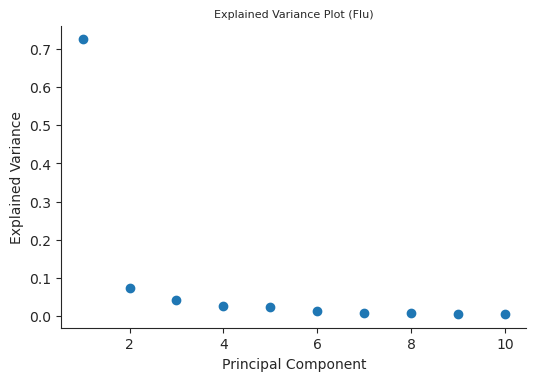

In [115]:
plt.plot(explained_variance_df_ha['principal components'].values.tolist(), explained_variance_df_ha["explained variance"].values.tolist(), 'o')

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

plt.title(f"Explained Variance Plot (Flu)")

#plt.savefig(snakemake.output.Explained_variance_PCA)

In [116]:
merged_pca_df_ha = principalDf_ha.merge(node_df[["strain", "date", "y", "clade_membership"]], on="strain")
merged_pca_df_concatenated = principalDf_concatenated.merge(node_df[["strain", "date", "y", "clade_membership"]], on="strain")

In [117]:
explained_variance_PCA_ha = explained_variance_df_ha["explained variance"].values.tolist()
explained_variance_PCA_concatenated = explained_variance_df_concatenated["explained variance"].values.tolist()

In [118]:
list_of_chart_ha = linking_tree_with_plots_brush(merged_pca_df_ha,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA_ha[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"], domain, range_)

list_of_chart_concatenated = linking_tree_with_plots_brush(merged_pca_df_concatenated,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA_concatenated[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"], domain, range_)
PCAFluBrush_ha = list_of_chart_ha[0]|list_of_chart_ha[1]|list_of_chart_ha[2]
PCAFluBrush_concatenated = list_of_chart_concatenated[0]|list_of_chart_concatenated[1]|list_of_chart_concatenated[2]

alt.vconcat(PCAFluBrush_ha,PCAFluBrush_concatenated)
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.VConcatChart(...)

# Running MDS on the Dataset

In [90]:
#MDS_df = pd.read_csv(mds_df,index_col=0)
MDS_df_ha = pd.read_csv("results/embed_mds_ha.csv",index_col=0)
MDS_df_concatenated = pd.read_csv("results/embed_mds_concatenated.csv",index_col=0)

In [91]:
merged_mds_df_ha = MDS_df_ha.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")
merged_mds_df_concatenated = MDS_df_concatenated.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [92]:
merged_mds_df_ha

,strain,mds1,mds2,mds3,mds4,mds5,mds6,mds7,mds8,mds9,mds10,mds_label,date,y,clade_membership,clade_membership_color
0,A/Alabama/06/2017,-6.631778,0.380252,-3.261285,-3.671127,-5.592623,-1.682792,3.907750,0.150084,-0.564304,1.890114,3,2017.10,367,A2/re,A2/re
1,A/Washington/93/2016,-6.580769,0.521334,-3.287388,-3.902616,-5.539968,-1.726514,3.819186,0.117556,-0.635211,2.034741,3,2016.93,363,A2/re,A2/re
2,A/Alaska/09/2017,-7.070817,-0.680675,-2.842953,-5.208878,-5.568483,-1.181507,2.880798,-0.096859,-1.668350,0.730751,3,2017.14,374,A2/re,A2/re
3,A/Texas/74/2017,-6.572608,-0.811248,-2.275141,-4.880899,-5.416157,-1.210922,2.882411,-0.329584,-1.896934,-0.135720,3,2017.22,372,A2/re,A2/re
4,A/Arizona/39/2017,-7.094397,-0.515977,-2.385266,-3.784942,-4.542513,-1.496152,3.102381,-0.427635,-1.523714,1.312062,3,2017.46,373,A2/re,A2/re
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,A/Tokyo/DS7-130/2016,-19.531101,8.248742,28.615543,-30.367121,5.360803,24.207614,-0.439223,-5.996433,-10.859047,-50.098936,0,2016.96,11,A2/re,A2/re
746,A/Ishikawa/DS7-153/2016,-19.666539,22.905023,26.432226,-41.218603,2.226368,31.655218,-3.174811,8.955661,-1.835243,-57.823342,0,2016.96,12,A2/re,A2/re
747,A/Tokyo/DS7-334/2017,-3.845324,2.921744,8.844804,-7.760377,-5.212303,17.035331,7.964199,3.984030,-14.587283,-38.238063,0,2017.03,23,A2/re,A2/re
748,A/Tokyo/DS7-63/2016,7.171322,-1.035403,6.949848,-31.897599,-13.037312,13.562322,4.498577,-0.124980,-12.316841,-37.196730,-1,2016.93,24,A2/re,A2/re


In [93]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df_ha,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership_color:N', domain, range_)
chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df_ha,'mds3','mds4',"mds3","mds4",['strain','clade_membership'],'clade_membership_color:N', domain, range_)
chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df_ha,'mds5','mds6',"mds5","mds6",['strain','clade_membership'],'clade_membership_color:N', domain, range_)
chart_12_mds|chart_34_mds|chart_56_mds

alt.HConcatChart(...)

In [94]:
list_of_chart_ha = linking_tree_with_plots_brush(merged_mds_df_ha,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart_ha = list_of_chart_ha[0]|list_of_chart_ha[1]
list_of_chart_concatenated = linking_tree_with_plots_brush(merged_mds_df_concatenated,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart_concat = list_of_chart_concatenated[0]|list_of_chart_concatenated[1]
alt.vconcat(chart_ha, chart_concat)

alt.VConcatChart(...)

# Running T-SNE on the Dataset 

In [58]:
TSNE_df_ha = pd.read_csv("results/embed_t-sne_ha.csv",index_col=0)
TSNE_df_concatenated = pd.read_csv("results/embed_t-sne_concatenated.csv",index_col=0)

In [60]:
merged_tsne_df_ha = TSNE_df_ha.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")
merged_tsne_df_concatenated = TSNE_df_concatenated.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [61]:
scatterplot_with_tooltip_interactive(merged_tsne_df_ha,'tsne_x','tsne_y','tsne_x','tsne_y',['strain', "clade_membership"],'clade_membership:N', domain, range_)

alt.Chart(...)

In [62]:
scatterplot_with_tooltip_interactive(merged_tsne_df_concatenated,'tsne_x','tsne_y','tsne_x','tsne_y',['strain', "clade_membership"],'clade_membership:N', domain, range_)

alt.Chart(...)

In [66]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df_ha,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership:N',
    ["strain:N", "clade_membership:N"],
    domain,
    range_
)
chart_tsne = list_of_chart[0]|list_of_chart[1]
chart_tsne

alt.HConcatChart(...)

In [65]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df_concatenated,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership:N',
    ["strain:N", "clade_membership:N"],
    domain,
    range_
)
chart_tsne = list_of_chart[0]|list_of_chart[1]
chart_tsne

alt.HConcatChart(...)

# Running UMAP on the Dataset

In [67]:
UMAP_df_ha = pd.read_csv("results/embed_umap_ha.csv",index_col=0)
UMAP_df_concatenated = pd.read_csv("results/embed_umap_concatenated.csv",index_col=0)

In [77]:
UMAP_df_concatenated

,umap_x,umap_y,umap_label
strain,,,
A/Arizona/39/2017,-0.608578,1.769676,1
A/Santiago/p019d0/2017,-1.150013,1.641340,1
A/Shanghai/2/2016,-1.398148,1.114893,1
A/Shanghai/1/2016,-1.052194,0.889635,1
A/Shanghai/26/2017,-1.161886,1.894363,1
...,...,...,...
A/MUWRP-Uganda/705/2017,-2.114980,3.604116,1
A/Keelung/0026/2016,-2.861363,3.170482,1
A/Kenya/028/2017,-5.973404,-2.134306,1


In [68]:
merged_umap_df_ha = UMAP_df_ha.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")
merged_umap_df_concatenated = UMAP_df_concatenated.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [78]:
merged_umap_df_ha

,strain,umap_x,umap_y,umap_label,date,y,clade_membership,clade_membership_color
0,A/Busan/1343/2018,17.807820,8.253476,-1,2018.21,1150,A1b/135N,A1b/135N
1,A/Incheon/1320/2018,17.672860,8.118483,-1,2018.19,1121,A1b/135N,A1b/135N
2,A/Seoul/739/2017,17.765017,8.210657,-1,2017.56,1120,A1b/135N,A1b/135N
3,A/Seoul/1287/2018,17.990704,8.436352,-1,2018.17,973,A1b/135K,A1b/135K
4,A/Chungbuk/107/2016,17.961660,8.407328,-1,2016.05,1,3c3,other
...,...,...,...,...,...,...,...,...
277,A/MUWRP-Uganda/705/2017,-6.804324,4.818766,3,2017.43,93,3c2.A,3c2.A
278,A/Keelung/0026/2016,-5.602932,5.002468,1,2016.04,96,3c2.A,3c2.A
279,A/Kenya/028/2017,-4.883677,6.184576,1,2017.43,1069,A1b,A1b
280,A/Moscow/CRIE-226/2017,2.819120,5.273807,1,2017.08,194,A3,A3


In [69]:
scatterplot_with_tooltip_interactive(merged_umap_df_ha,'umap_x','umap_y','umap_x','umap_y',['strain', "clade_membership"],'clade_membership:N', domain, range_)

alt.Chart(...)

In [70]:
scatterplot_with_tooltip_interactive(merged_umap_df_concatenated,'umap_x','umap_y','umap_x','umap_y',['strain', "clade_membership"],'clade_membership:N', domain, range_)

alt.Chart(...)

In [71]:
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df_ha,
    ['umap_x','umap_y'],
    ['umap_x','umap_y'],
    'clade_membership:N',
    ["strain:N", "clade_membership:N"],
    domain,
    range_
)
chart_umap = list_of_chart[0]|list_of_chart[1]
chart_umap

alt.HConcatChart(...)

# Linking all plots together clickable with Tree

In [120]:
data = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA_ha[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA_ha[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership:N',
    ['strain'],
    domain,
    range_
)

In [121]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.vconcat(data[0],embeddings)
fullChart
#fullChart.save("../docs/FullLinkedChartBrushableFlu.html")
#fullChart.save(snakemake.output.fullChart)
#save(fullChart, snakemake.output.fullChartPNG, scale_factor=2.0)

alt.VConcatChart(...)

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

In [ ]:
import matplotlib.gridspec as gridspec

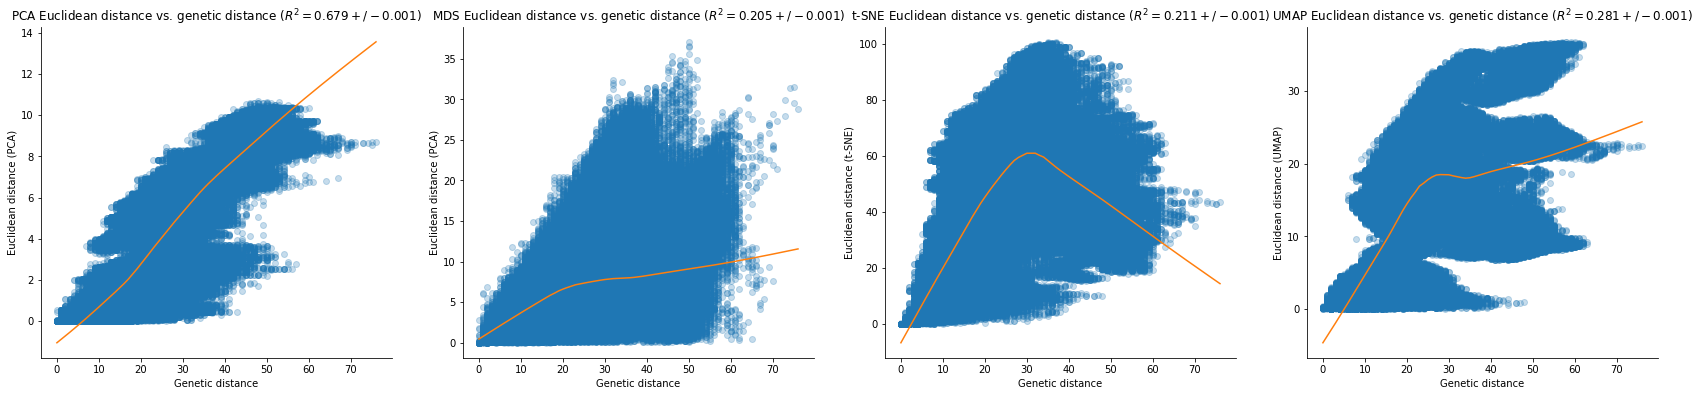

In [126]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.tight_layout(pad=8.0)
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.8)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (PCA)")
ax2.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")



mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


sns.despine()
plt.savefig(snakemake.output.Scatterplot, dpi=300)

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [127]:
Genetic_KDE_df = pd.read_csv(KDE_genetic,index_col=0)
Genetic_KDE_metadata_df = pd.read_csv(KDE_genetic_metadata, index_col=0)

In [128]:
import matplotlib.gridspec as gridspec

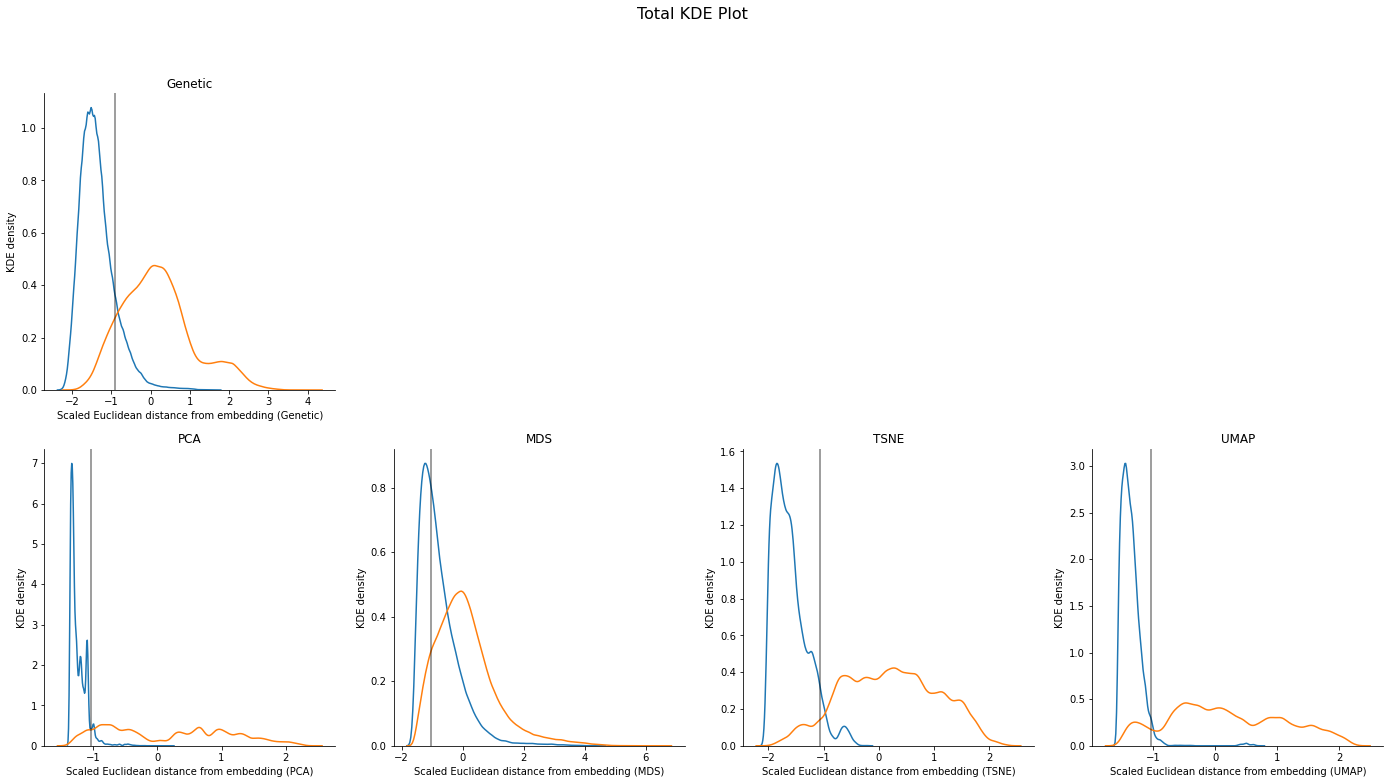

In [131]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(16, 8), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.4, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax1.legend(frameon=False)
ax1.set_title('Genetic')
ax1.set_xlabel("Scaled Euclidean distance (Genetic)")
ax1.set_ylabel("KDE density")

#PCA
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax2)
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax2)
ax2.axvline(x=PCA_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title('PCA')
ax2.set_xlabel("Scaled Euclidean distance (PCA)")
ax2.set_ylabel("KDE density")

#MDS
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax3)
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax3)
ax3.axvline(x=MDS_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax3.legend(frameon=False)
ax3.set_title('MDS')
ax3.set_xlabel("Scaled Euclidean distance (MDS)")
ax3.set_ylabel("KDE density")

#TSNE
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax4)
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax4)
ax4.axvline(x=TSNE_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax4.legend(frameon=False)
ax4.set_title('TSNE')
ax4.set_xlabel("Scaled Euclidean distance (TSNE)")
ax4.set_ylabel("KDE density")

#UMAP
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax5)
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax5)
ax5.axvline(x=UMAP_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax5.legend(frameon=False)
ax5.set_title('UMAP')
ax5.set_xlabel("Scaled Euclidean distance (UMAP)")
ax5.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()
plt.savefig(snakemake.output.KDE_density, dpi=600, bbox_inches='tight')

# Supplemental Figures

In [45]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]

chart.save(snakemake.output.MDS_Supplement)
save(chart, snakemake.output.MDS_Supplement_PNG)

In [46]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]

chart.save(snakemake.output.PCA_Supplement)
save(chart, snakemake.output.PCA_Supplement_PNG)